## Imports

In [19]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

## Load Data

In [28]:
pizza_dir = './data/input/pizza_not_pizza/pizza' 
not_pizza_dir = './data/input/pizza_not_pizza/not_pizza'
data_dir = './data/input/pizza_not_pizza'
#pizza_generated_dir = './data/input/pizza_not_pizza_generated/pizza_generated' 
#not_pizza_generated_dir = './data/input/pizza_not_pizza_generated/not_pizza_generated'
#data_generated_dir = './data/input/pizza_not_pizza_generated'

In [29]:
num_pizza_images = len(os.listdir(pizza_dir))
non_pizza_images = len(os.listdir(not_pizza_dir))
print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {non_pizza_images}')

#num_pizza_generated_images = len(os.listdir(pizza_generated_dir))
#non_pizza_generated_images = len(os.listdir(not_pizza_generated_dir))
#print(f'Number of Generated Pizza images: {num_pizza_generated_images}')
#print(f'Number of Generated Non-Pizza images: {non_pizza_generated_images}')

Number of Pizza images: 983
Number of Non-Pizza images: 983


## Train/Validation Data Sets

In [5]:
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 1574 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


In [6]:
images, labels = train_data.next()
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

## Generated Training Data

In [ ]:
train_data_generated = data_gen.flow_from_directory(data_generated_dir, 
                                                    target_size = (224, 224), 
                                                    batch_size = 32,
                                                    subset = 'training',
                                                    class_mode = 'binary')

In [ ]:
images, labels = train_data_generated.next()
len(images), len(labels), images[0].shape

## Visualizing Images

In [7]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """
    
    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (10, 5))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()       
    plt.show()

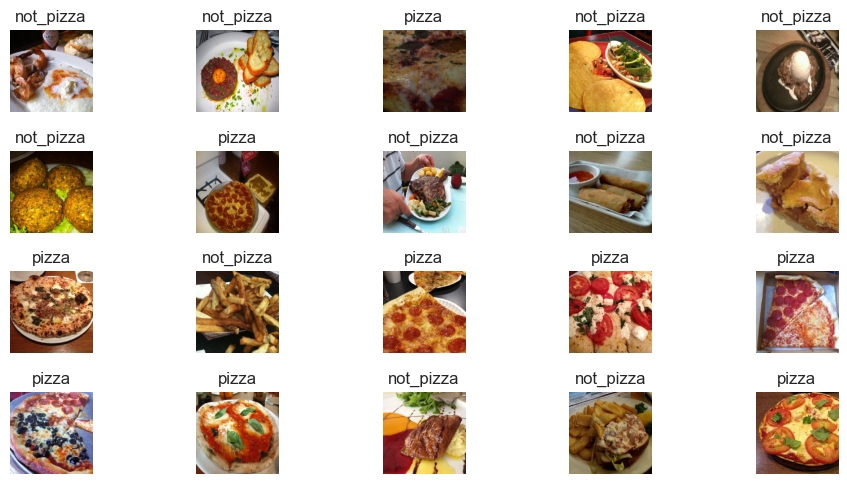

In [8]:
plot_random_images()

## Baseline Model

In [9]:
tf.random.set_seed(42)
model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer    
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # First Convolutional layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # Second Convolutional layer
    Flatten(),
    Dense(1, activation = 'sigmoid') # Output layer  
])

model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs= 5,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/5
50/50 [==============================] - 46s 913ms/step - loss: 1.1971 - accuracy: 0.6125 - val_loss: 0.5895 - val_accuracy: 0.7143
Epoch 2/5
50/50 [==============================] - 47s 937ms/step - loss: 0.5101 - accuracy: 0.7732 - val_loss: 0.6517 - val_accuracy: 0.7066
Epoch 3/5
50/50 [==============================] - 45s 890ms/step - loss: 0.3503 - accuracy: 0.8729 - val_loss: 0.5522 - val_accuracy: 0.7398
Epoch 4/5
50/50 [==============================] - 44s 887ms/step - loss: 0.2109 - accuracy: 0.9288 - val_loss: 0.6525 - val_accuracy: 0.6862
Epoch 5/5
50/50 [==============================] - 44s 882ms/step - loss: 0.0888 - accuracy: 0.9778 - val_loss: 0.6827 - val_accuracy: 0.7219


## Visualizing the results

In [14]:
# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Plots the curves of both loss and accuracy
    """

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize = (20, 5))

    # Plotting loss
    ax1 = sns.lineplot(x = epochs, y = loss, label='Training Loss', ax= ax[0])
    ax1 = sns.lineplot(x = epochs, y = val_loss, label='Validation Loss', ax= ax[0])
    ax1.set(title = 'Loss', xlabel = 'Epochs')

    # Plot accuracy
    ax2 = sns.lineplot(x = epochs, y = accuracy, label='Training Accuracy', ax= ax[1])
    ax2 = sns.lineplot(x = epochs, y = val_accuracy, label='Validation Accuracy', ax=ax[1])
    ax2.set(title = 'Accuracy', xlabel = 'Epochs')

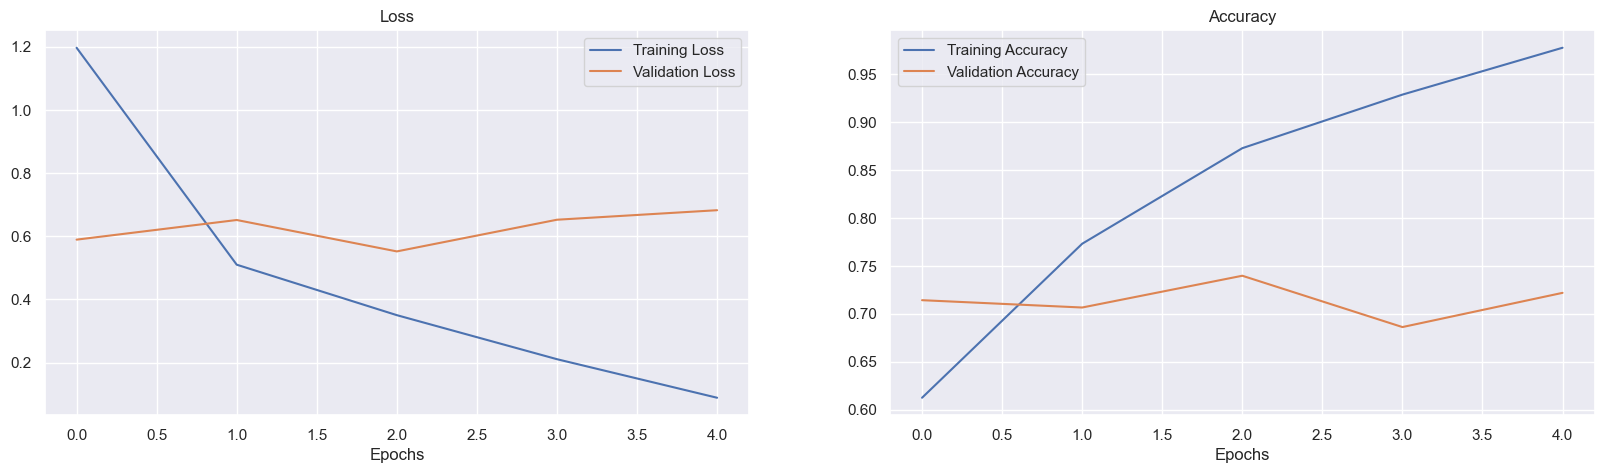

In [15]:
plot_loss_curves(history_1)

## Improving the Model

There are lot of things we can change for improving the model such as:

    Increasing the number of epochs
    Adding Max Pooling Layer
    Adding more convolutional layers
    Changing the number of filters
    Changing the size of our filters
    Changing the pool size of Max Pooling layer



In [12]:
model_2 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs= 20,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/20
50/50 [==============================] - 21s 407ms/step - loss: 0.6800 - accuracy: 0.5820 - val_loss: 0.6543 - val_accuracy: 0.6888
Epoch 2/20
50/50 [==============================] - 20s 408ms/step - loss: 0.6457 - accuracy: 0.6518 - val_loss: 0.6292 - val_accuracy: 0.6403
Epoch 3/20
50/50 [==============================] - 21s 411ms/step - loss: 0.6187 - accuracy: 0.6773 - val_loss: 0.5965 - val_accuracy: 0.7092
Epoch 4/20
50/50 [==============================] - 20s 402ms/step - loss: 0.5947 - accuracy: 0.6938 - val_loss: 0.6084 - val_accuracy: 0.6786
Epoch 5/20
50/50 [==============================] - 21s 413ms/step - loss: 0.5815 - accuracy: 0.7084 - val_loss: 0.5872 - val_accuracy: 0.7015
Epoch 6/20
50/50 [==============================] - 23s 452ms/step - loss: 0.5623 - accuracy: 0.7236 - val_loss: 0.5533 - val_accuracy: 0.7500
Epoch 7/20
50/50 [==============================] - 22s 437ms/step - loss: 0.5518 - accuracy: 0.7243 - val_loss: 0.5655 - val_accuracy: 0.7066

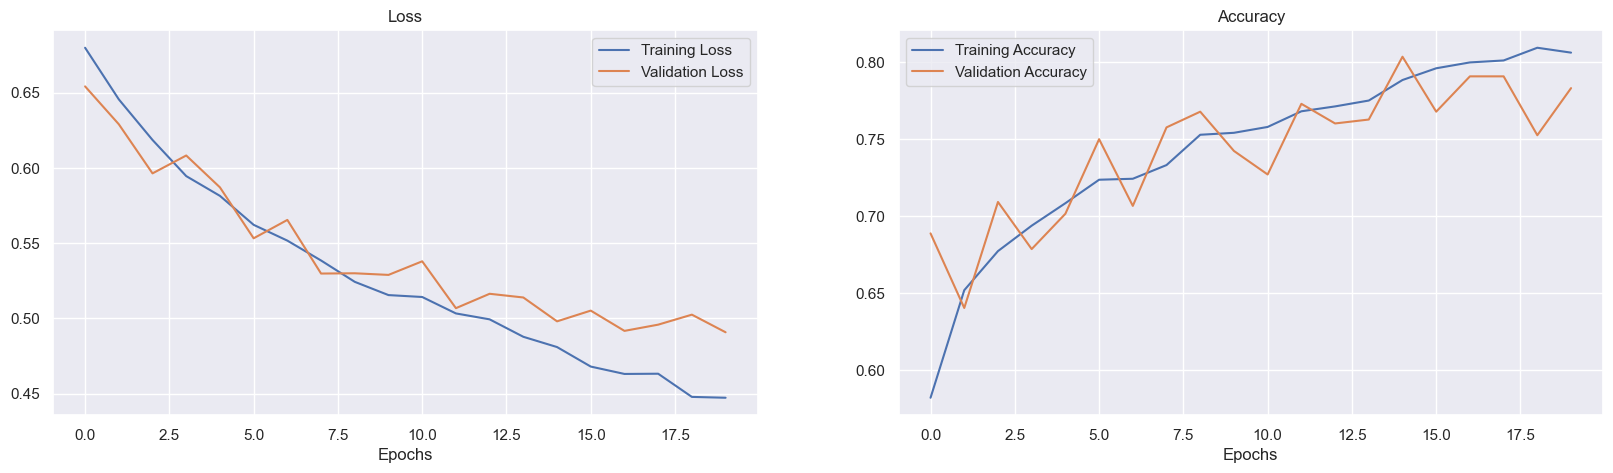

In [13]:
plot_loss_curves(history_2)

## Training Model with generated Data

In [ ]:
model_3 = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

model_3.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

history_3 = model_2.fit(train_data_generated, # using generated data
                        epochs= 20,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

In [ ]:
plot_loss_curves(history_3)